#Lid driven cavity

$$
\newcommand{\DdQq}[2]{{\mathrm D}_{#1}{\mathrm Q}_{#2}}
\newcommand{\drondt}{\partial_t}
\newcommand{\drondx}{\partial_x}
\newcommand{\drondy}{\partial_y}
\newcommand{\drondtt}{\partial_{tt}}
\newcommand{\drondxx}{\partial_{xx}}
\newcommand{\drondyy}{\partial_{yy}}
\newcommand{\dx}{\Delta x}
\newcommand{\dt}{\Delta t}
\newcommand{\grandO}{{\mathcal O}}
\newcommand{\density}[2]{\,f_{#1}^{#2}}
\newcommand{\fk}[1]{\density{#1}{\vphantom{\star}}}
\newcommand{\fks}[1]{\density{#1}{\star}}
\newcommand{\moment}[2]{\,m_{#1}^{#2}}
\newcommand{\mk}[1]{\moment{#1}{\vphantom{\star}}}
\newcommand{\mke}[1]{\moment{#1}{e}}
\newcommand{\mks}[1]{\moment{#1}{\star}}
$$

In this tutorial, we consider the classical $\DdQq{2}{9}$ and $\DdQq{3}{15}$ to simulate a lid driven acvity modeling by the Navier-Stokes equations. The $\DdQq{2}{9}$ is used in dimension $2$ and the $\DdQq{3}{15}$ in dimension $3$.

##The $\DdQq{2}{9}$ for Navier-Stokes

The $\DdQq{2}{9}$ is defined by:

* a space step $\dx$ and a time step $\dt$ related to the scheme velocity $\lambda$ by the relation $\lambda=\dx/\dt$,
* nine velocities $\{(0,0), (\pm1,0), (0,\pm1), (\pm1, \pm1)\}$, identified in pyLBM by the numbers $0$ to $8$,
* nine polynomials used to build the moments
$$ \{1, \lambda X, \lambda Y, 3E-4, (9E^2-21E+8)/2, 3XE-5X, 3YE-5Y,X^2-Y^2, XY\},$$
where $E = X^2+Y^2$.

* three conserved moments $\rho$, $q_x$, and $q_y$,
* nine relaxation parameters (three are $0$ corresponding to conserved moments): $\{0,0,0,s_\mu,s_\mu,s_\eta,s_\eta,s_\eta,s_\eta\}$, where $s_\mu$ and $s_\eta$ are in $(0,2)$,
* equilibrium value of the non conserved moments
$$
\begin{aligned}\mke{3} &= -2\rho + 3(q_x^2+q_y^2)/(\rho_0\lambda^2), \\ \mke{4} &= \rho+3(q_x^2+q_y^2)/(2\rho_0\lambda^2), \\ \mke{5} &= -q_x/\lambda, \\ \mke{6} &= -q_y/\lambda, \\ \mke{7} &= (q_x^2-q_y^2)/(\rho_0\lambda^2), \\ \mke{8} &= q_xq_y/(\rho_0\lambda^2),\end{aligned}
$$
where $\rho_0$ is a given scalar.

This scheme is consistant at second order with the following equations (taken $\rho_0=1$)
$$
\begin{gather*} \drondt\rho + \drondx q_x + \drondy q_y = 0,\\ \drondt q_x + \drondx (q_x^2+p) + \drondy (q_xq_y) = \mu \drondx (\drondx q_x + \drondy q_y ) + \eta (\drondxx+\drondyy)q_x, \\ \drondt q_y + \drondx (q_xq_y) + \drondy (q_y^2+p) = \mu \drondy (\drondx q_x + \drondy q_y ) + \eta (\drondxx+\drondyy)q_y,\end{gather*}
$$
with $p=\rho\lambda^2/3$.

We write the dictionary for a simulation of the Navier-Stokes equations on $(0,1)^2$.

In order to impose the boundary conditions, we use the bounce-back conditions to fix $q_x=q_y=0$ at south, east, and west and $q_x=\rho u$, $q_y=0$ at north. The driven velocity $u$ could be $u=\lambda/10$.

The solution is governed by the Reynolds number $Re = \rho_0u / \eta$. We fix the relaxation parameters to have $Re=1000$. The relaxation parameters related to the bulk viscosity $\mu$ should be large enough to ensure the stability (for instance $\mu=10^{-3}$).

We compute the stationary solution of the problem obtained for large enough final time. We plot the solution with the function quiver of matplotlib.

In [1]:
%matplotlib inline

Reynolds number:  1.000e+03
Bulk viscosity :  1.000e-03
Shear viscosity:  1.000e-04
relaxation parameters: [0.0, 0.0, 0.0, 1.1312217194570136, 1.1312217194570136, 1.8573551263001487, 1.8573551263001487, 1.8573551263001487, 1.8573551263001487]


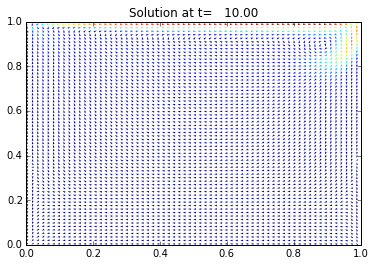

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import pyLBM

X, Y, LA = sp.symbols('X, Y, LA')
rho, qx, qy = sp.symbols('rho, qx, qy')

def bc(f, m, x, y, scheme):
    m[:, 1] = m[:, 0] * vup
    m[:, 2] = 0.
    scheme.equilibrium(m)
    scheme.m2f(m, f)

def plot(sol):
    pas = 2
    y, x = np.meshgrid(sol.domain.x[1][1:-1:pas], sol.domain.x[0][1:-1:pas])
    u = sol.m[0][1][1:-1:pas,1:-1:pas] / sol.m[0][0][1:-1:pas,1:-1:pas]
    v = sol.m[0][2][1:-1:pas,1:-1:pas] / sol.m[0][0][1:-1:pas,1:-1:pas]
    nv = np.sqrt(u**2+v**2)
    normu = nv.max()
    u = u / (nv+1e-5)
    v = v / (nv+1e-5)
    plt.quiver(x, y, u, v, nv, pivot='mid')
    plt.title('Solution at t={0:8.2f}'.format(sol.t))
    plt.show()

# parameters
Re = 1000
dx = 1./128  # spatial step
la = 1.      # velocity of the scheme
Tf = 10     # final time of the simulation
vup = la/10    # maximal velocity obtained in the middle of the channel
rhoo = 1.    # mean value of the density
mu = 1.e-3   # bulk viscosity
eta = rhoo*vup/Re  # shear viscosity
# initialization
xmin, xmax, ymin, ymax = 0., 1., 0., 1.
dummy = 3.0/(la*rhoo*dx)
s_mu = 1.0/(0.5+mu*dummy)
s_eta = 1.0/(0.5+eta*dummy)
s_q = s_eta
s_es = s_mu
s  = [0.,0.,0.,s_mu,s_es,s_q,s_q,s_eta,s_eta]
dummy = 1./(LA**2*rho)
qx2 = dummy*qx**2
qy2 = dummy*qy**2
q2  = qx2+qy2
qxy = dummy*qx*qy

print "Reynolds number: {0:10.3e}".format(Re)
print "Bulk viscosity : {0:10.3e}".format(mu)
print "Shear viscosity: {0:10.3e}".format(eta)
print "relaxation parameters: {0}".format(s)

dico = {
    'box':{'x':[xmin, xmax], 'y':[ymin, ymax], 'label':[0,0,0,1]},
    'space_step':dx,
    'scheme_velocity':la,
    'parameters':{LA:la},
    'schemes':[
        {
            'velocities':range(9),
            'conserved_moments':[rho, qx, qy],
            'polynomials':[
                1, LA*X, LA*Y,
                3*(X**2+Y**2)-4,
                (9*(X**2+Y**2)**2-21*(X**2+Y**2)+8)/2,
                3*X*(X**2+Y**2)-5*X, 3*Y*(X**2+Y**2)-5*Y,
                X**2-Y**2, X*Y
            ],
            'relaxation_parameters':s,
            'equilibrium':[
                rho, qx, qy,
                -2*rho + 3*q2,
                rho+3/2*q2,
                -qx/LA, -qy/LA,
                qx2-qy2, qxy
            ],
            'init':{rho:rhoo, qx:0., qy:0.},
        },
    ],
    'boundary_conditions':{
        0:{'method':{0: pyLBM.bc.bouzidi_bounce_back}, 'value':None},
        1:{'method':{0: pyLBM.bc.bouzidi_bounce_back}, 'value':bc}
    },
    'generator': pyLBM.generator.CythonGenerator,
}

sol = pyLBM.Simulation(dico)

while (sol.t<Tf):
    sol.one_time_step()

sol.f2m()
plot(sol)

##The $\DdQq{3}{15}$ for Navier-Stokes

The $\DdQq{3}{15}$ is defined by:

* a space step $\dx$ and a time step $\dt$ related to the scheme velocity $\lambda$ by the relation $\lambda=\dx/\dt$,
* fifteen velocities $\{(0,0,0), (\pm1,0,0), (0,\pm1,0), (0,0,\pm1), (\pm1, \pm1,\pm1)\}$, identified in pyLBM by the numbers $\{0,\ldots,6,19,\ldots,26\}$,
* fifteen polynomials used to build the moments
$$ \{1, E-2, (15E^2-55E+32)/2, X, X(5E-13)/2, Y, Y(5E-13)/2, Z, Z(5E-13)/2, 3X^2-E, Y^2-Z^2, XY, YZ, ZX, XYZ \},$$
where $E = X^2+Y^2+Z^2$.

* four conserved moments $\rho$, $q_x$, $q_y$, and $q_z$,
* fifteen relaxation parameters (four are $0$ corresponding to conserved moments): $\{0, s_1, s_2, 0, s_4, 0, s_4, 0, s_4, s_9, s_9, s_{11}, s_{11}, s_{11}, s_{14}\}$,
* equilibrium value of the non conserved moments

$$
\begin{aligned} \mke{1} &= -\rho + q_x^2 + q_y^2 + q_z^2,\\ \mke{2} &= -\rho,\\ \mke{4} &= -7q_x/3, \\ \mke{6} &= -7q_y/3, \\ \mke{8} &= -7q_z/3, \\ \mke{9} &= (2q_x^2-(q_y^2+q_z^2))/3, \\ \mke{10} &= q_y^2-q_z^2, \\ \mke{11} &= q_xq_y, \\ \mke{12} &= q_yq_z, \\ \mke{13} &= q_zq_x, \\ \mke{14} &= 0. \end{aligned}
$$

This scheme is consistant at second order with the Navier-Stokes equations with the shear viscosity $\eta$ and the relaxation parameter $s_9$ linked by the relation
$$ s_9 = \frac{2}{1 + 6\eta /\dx}.$$

We write a dictionary for a simulation of the Navier-Stokes equations on $(0,1)^3$.

In order to impose the boundary conditions, we use the bounce-back conditions to fix $q_x=q_y=q_z=0$ at south, north, east, west, and bottom and $q_x=\rho u$, $q_y=q_z=0$ at top. The driven velocity $u$ could be $u=\lambda/10$.

We compute the stationary solution of the problem obtained for large enough final time. We plot the solution with the function quiver of matplotlib.

Reynolds number:  2.000e+03
Shear viscosity:  5.000e-05


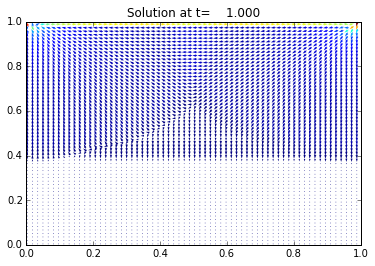

In [3]:
X, Y, Z, LA = sp.symbols('X, Y, Z, LA')
rho, qx, qy, qz = sp.symbols('rho, qx, qy, qz')

def bc(f, m, x, y, z, scheme):
    m[:, 3] = rhoo * vup
    m[:, 5] = 0.
    m[:, 7] = 0.
    scheme.equilibrium(m)
    scheme.m2f(m, f)

def plot(sol):
    plt.clf()
    pas = 2
    nz = int(sol.domain.N[1] / 2) + 1
    y, x = np.meshgrid(sol.domain.x[2][1:-1:pas], sol.domain.x[0][1:-1:pas])
    u = sol.m[0][3][1:-1:pas,nz,1:-1:pas] / sol.m[0][0][1:-1:pas,nz,1:-1:pas]
    v = sol.m[0][7][1:-1:pas,nz,1:-1:pas] / sol.m[0][0][1:-1:pas,nz,1:-1:pas]
    nv = np.sqrt(u**2+v**2)
    normu = nv.max()
    u = u / (nv+1e-5)
    v = v / (nv+1e-5)
    plt.quiver(x, y, u, v, nv, pivot='mid')
    plt.title('Solution at t={0:9.3f}'.format(sol.t))
    plt.pause(1.e-3)

# parameters
Re = 2000
dx = 1./128  # spatial step
la = 1.      # velocity of the scheme
Tf = 1      # final time of the simulation
vup = la/10  # maximal velocity obtained in the middle of the channel
rhoo = 1.    # mean value of the density
eta = rhoo*vup/Re  # shear viscosity
# initialization
xmin, xmax, ymin, ymax, zmin, zmax = 0., 1., 0., 1., 0., 1.
dummy = 3.0/(la*rhoo*dx)

s1 = 1.6
s2 = 1.2
s4 = 1.6
s9 = 1./(.5+dummy*eta)
s11 = s9
s14 = 1.2
s  = [0, s1, s2, 0, s4, 0, s4, 0, s4, s9, s9, s11, s11, s11, s14]

r = X**2+Y**2+Z**2

print "Reynolds number: {0:10.3e}".format(Re)
print "Shear viscosity: {0:10.3e}".format(eta)

dico = {
    'box':{
        'x':[xmin, xmax],
        'y':[ymin, ymax],
        'z':[zmin, zmax],
        'label':[0,0,0,0,0,1]
    },
    'space_step':dx,
    'scheme_velocity':la,
    'parameters':{LA:la},
    'schemes':[
        {
            'velocities':range(7) + range(19,27),
            'conserved_moments':[rho, qx, qy, qz],
            'polynomials':[
                1,
                r - 2, .5*(15*r**2-55*r+32),
                X, .5*(5*r-13)*X,
                Y, .5*(5*r-13)*Y,
                Z, .5*(5*r-13)*Z,
                3*X**2-r, Y**2-Z**2,
                X*Y, Y*Z, Z*X,
                X*Y*Z
            ],
            'relaxation_parameters':s,
            'equilibrium':[
                rho,
                -rho + qx**2 + qy**2 + qz**2,
                -rho,
                qx,
                -7./3*qx,
                qy,
                -7./3*qy,
                qz,
                -7./3*qz,
                1./3*(2*qx**2-(qy**2+qz**2)),
                qy**2-qz**2,
                qx*qy,
                qy*qz,
                qz*qx,
                0
            ],
            'init':{rho:rhoo, qx:0., qy:0.},
        },
    ],
    'boundary_conditions':{
        0:{'method':{0: pyLBM.bc.bouzidi_bounce_back}, 'value':None},
        1:{'method':{0: pyLBM.bc.bouzidi_bounce_back}, 'value':bc}
    },
    'generator': pyLBM.generator.CythonGenerator,
}

sol = pyLBM.Simulation(dico)

while (sol.t<Tf):
    sol.one_time_step()

sol.f2m()
plot(sol)
plt.show()